# Description

This notebook takes the combined csv file that has info about minutes played and team, season, week, opponent, home/away, and player names, and calculates accuracy of simple predictive models that:
- Take last 5 weeks average minutes played.
- Randomly takes minutes played from last 5 weeks

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly.express as px
# set numpy seed
np.random.seed(42)

In [2]:
# Load the combined data
csv_path = ('../datasets/black_dataframe/player_minutes_with_extra_columns_2425.csv')

df = pd.read_csv(csv_path)

In [3]:
df.columns

Index(['Unnamed: 0', 'season', 'team', 'week', 'date', 'opponent',
       'home_or_away', 'outcome', 'player', 'injured_or_suspended', 'reason',
       'minutes', 'xG', 'xA', 'xGC', 'bps', 'goals', 'assists',
       'goals_conceded'],
      dtype='object')

In [4]:
players = ['Aaron Cresswell', 'Aaron Wan-Bissaka', 'Aaron Ramsdale']

tmp_df = df.player.isin(players)
filtered_df = df[tmp_df] 

In [5]:
# Create an empty array to populate of shape (n, 38-TIME_SERIES_LENGTH, TIME_SERIES_LENGTH, N_PLAYERS)
N_PLAYERS = 53 # Max number of players for a team
TIME_SERIES_LENGTH = 6 # Number of previous weeks + current week

all_data_arr = np.zeros((len(df.team.unique()), 39-TIME_SERIES_LENGTH, TIME_SERIES_LENGTH, N_PLAYERS))

TEAMS = df.team.unique()

for i, team in enumerate(TEAMS):
    team_data = df[df['team'] == team]
    PLAYERS = team_data['player'].unique()

    for j, player in enumerate(PLAYERS):

        # Get the data for the specific team and player
        player_data = df[(df['team'] == team) & (df['player'] == player)]

        # Sort by week and reset index
        player_data = player_data.sort_values('week').reset_index(drop=True)

        # Extract the minutes played
        minutes_played = player_data['minutes'].to_numpy()

        # Split into chunks of 6 weeks
        for k in range(0, len(minutes_played) - TIME_SERIES_LENGTH + 1):
            chunk = minutes_played[k:k + TIME_SERIES_LENGTH]
            if len(chunk) == TIME_SERIES_LENGTH:
                all_data_arr[i, k, :, j] = chunk

In [6]:
# Split out 3 random teams for testing 
test_teams = np.random.randint(0, len(TEAMS), size=3)

# split train and test data using test_teams
train_data = all_data_arr[np.isin(np.arange(len(TEAMS)), test_teams, invert=True)]
test_data = all_data_arr[test_teams]

## Train on individual players

In [7]:
# reorder the array to be (0, 1, 3, 2)
train_data = np.transpose(train_data, (0, 1, 3, 2))
test_data = np.transpose(test_data, (0, 1, 3, 2))

# collapse first 3 dimensions to create a single dimension
train_data = train_data.reshape(-1, TIME_SERIES_LENGTH)
test_data = test_data.reshape(-1, TIME_SERIES_LENGTH)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch.nn.functional as F

class PlayerMinutes1DCNN(nn.Module):
    def __init__(self, input_length=6, num_filters=64, kernel_size=3, dropout_rate=0.2):
        super(PlayerMinutes1DCNN, self).__init__()
        
        # 1D Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, 
                              kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters*2, 
                              kernel_size=kernel_size, padding=1)
        self.conv3 = nn.Conv1d(in_channels=num_filters*2, out_channels=num_filters, 
                              kernel_size=kernel_size, padding=1)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm1d(num_filters)
        self.bn2 = nn.BatchNorm1d(num_filters*2)
        self.bn3 = nn.BatchNorm1d(num_filters)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
        
        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(num_filters, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)  # Predict next week's minutes
        
    def forward(self, x):
        # Reshape for 1D conv: (batch_size, channels, sequence_length)
        x = x.unsqueeze(1)  # Add channel dimension
        
        # Convolutional layers with ReLU and batch norm
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        
        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.squeeze(-1)  # Remove last dimension
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

def prepare_data_for_cnn(train_data, test_data):
    """
    Prepare data for CNN training - create X,y pairs where:
    X = first 5 weeks of minutes
    y = 6th week minutes (target)
    """
    # Remove rows with all zeros (padding)
    train_mask = np.any(train_data != 0, axis=1)
    test_mask = np.any(test_data != 0, axis=1)
    
    train_clean = train_data[train_mask]
    test_clean = test_data[test_mask]
    
    # Split into features (first 5 weeks) and target (6th week)
    X_train = train_clean[:, :5]  # First 5 weeks
    y_train = train_clean[:, 5]   # 6th week (target)
    
    X_test = test_clean[:, :5]
    y_test = test_clean[:, 5]
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)
    
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

def train_cnn_model(X_train, y_train, X_test, y_test, epochs=500, batch_size=32, lr=0.001):
    """
    Train the 1D CNN model
    """
    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model, loss function, and optimizer
    model = PlayerMinutes1DCNN(input_length=5)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    # Training loop
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs, y_test)
            val_losses.append(val_loss.item())
            
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        scheduler.step(val_loss)
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return model, train_losses, val_losses

def evaluate_cnn_model(model, X_test, y_test):
    """
    Evaluate the trained CNN model
    """
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        
    # Convert to numpy for evaluation
    y_pred = predictions.numpy().flatten()
    y_true = y_test.numpy().flatten()
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"CNN Model Performance:")
    print(f"MAE: {mae:.2f} minutes")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f} minutes")
    
    return y_pred, y_true

# Add this to your notebook after the existing code:

# Prepare data for CNN
X_train, y_train, X_test, y_test = prepare_data_for_cnn(train_data, test_data)

print(f"Training data shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")

# Train the CNN model
print("\nTraining 1D CNN model...")
cnn_model, train_losses, val_losses = train_cnn_model(X_train, y_train, X_test, y_test, epochs=500)

# Evaluate the model
print("\nEvaluating CNN model...")
cnn_predictions, cnn_true = evaluate_cnn_model(cnn_model, X_test, y_test)

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('CNN Training Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(cnn_true, cnn_predictions, alpha=0.5)
plt.plot([0, 90], [0, 90], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Minutes')
plt.ylabel('Predicted Minutes')
plt.title('CNN Predictions vs Actual')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Training data shape: torch.Size([11732, 5])
Training target shape: torch.Size([11732, 1])
Test data shape: torch.Size([1948, 5])
Test target shape: torch.Size([1948, 1])

Training 1D CNN model...
Epoch 0/500, Train Loss: 1512.6221, Val Loss: 750.3190
Epoch 20/500, Train Loss: 947.4413, Val Loss: 719.5253
Epoch 40/500, Train Loss: 936.2652, Val Loss: 727.6428
Epoch 60/500, Train Loss: 933.2164, Val Loss: 725.0150
Epoch 80/500, Train Loss: 934.7446, Val Loss: 730.2109
Epoch 100/500, Train Loss: 932.2604, Val Loss: 729.2742
Epoch 120/500, Train Loss: 930.8896, Val Loss: 727.1023
Epoch 140/500, Train Loss: 926.1905, Val Loss: 725.6666
Epoch 160/500, Train Loss: 931.7489, Val Loss: 729.0132
Epoch 180/500, Train Loss: 931.3816, Val Loss: 725.0573
Epoch 200/500, Train Loss: 936.9420, Val Loss: 729.1337
Epoch 220/500, Train Loss: 927.8553, Val Loss: 726.8563
Epoch 240/500, Train Loss: 930.0081, Val Loss: 727.2723
Epoch 260/500, Train Loss: 933.3102, Val Loss: 727.8234
Epoch 280/500, Train Loss

## RNN

Training RNN models...

Training LSTM model...
Epoch 0/100, Train Loss: 1699.6385, Val Loss: 742.4810
Epoch 20/100, Train Loss: 921.7764, Val Loss: 719.7449
Epoch 40/100, Train Loss: 891.3267, Val Loss: 766.3463
Epoch 60/100, Train Loss: 875.0099, Val Loss: 808.7694
Epoch 80/100, Train Loss: 871.5582, Val Loss: 806.4664

Evaluating LSTM model...
LSTM Model Performance:
MAE: 23.58 minutes
MSE: 808.17
RMSE: 28.43 minutes

Training GRU model...
Epoch 0/100, Train Loss: 1661.0381, Val Loss: 744.7751
Epoch 20/100, Train Loss: 924.4298, Val Loss: 721.5726
Epoch 40/100, Train Loss: 885.0404, Val Loss: 802.1971
Epoch 60/100, Train Loss: 867.1784, Val Loss: 788.3437
Epoch 80/100, Train Loss: 864.4994, Val Loss: 785.3389

Evaluating GRU model...
GRU Model Performance:
MAE: 22.97 minutes
MSE: 786.24
RMSE: 28.04 minutes

Training RNN model...
Epoch 0/100, Train Loss: 1576.1429, Val Loss: 768.7263
Epoch 20/100, Train Loss: 943.5869, Val Loss: 751.2602
Epoch 40/100, Train Loss: 910.2206, Val Loss: 7

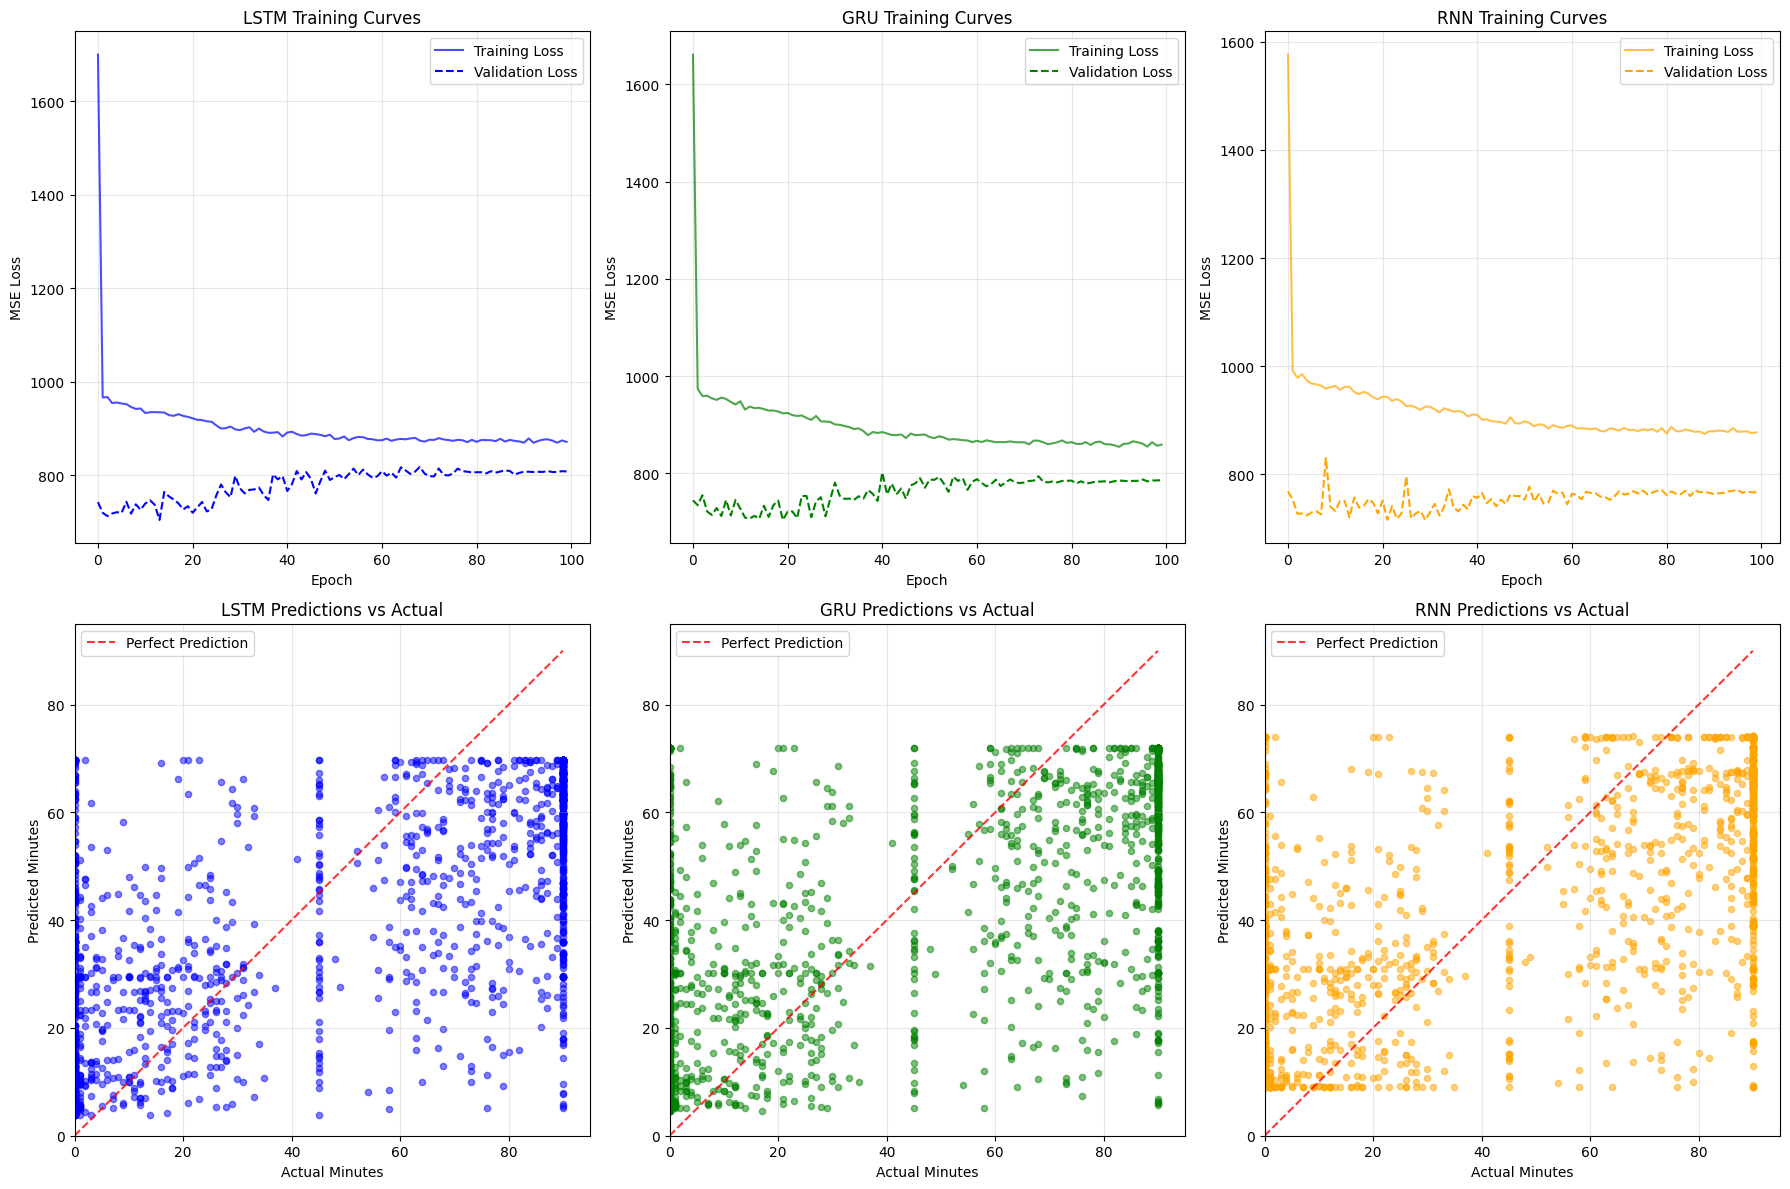


MODEL COMPARISON SUMMARY
LSTM     | MAE:  23.58 | MSE:   808.17 | RMSE:  28.43
GRU      | MAE:  22.97 | MSE:   786.24 | RMSE:  28.04
RNN      | MAE:  22.64 | MSE:   767.13 | RMSE:  27.70
CNN      | MAE:  21.60 | MSE:   736.79 | RMSE:  27.14


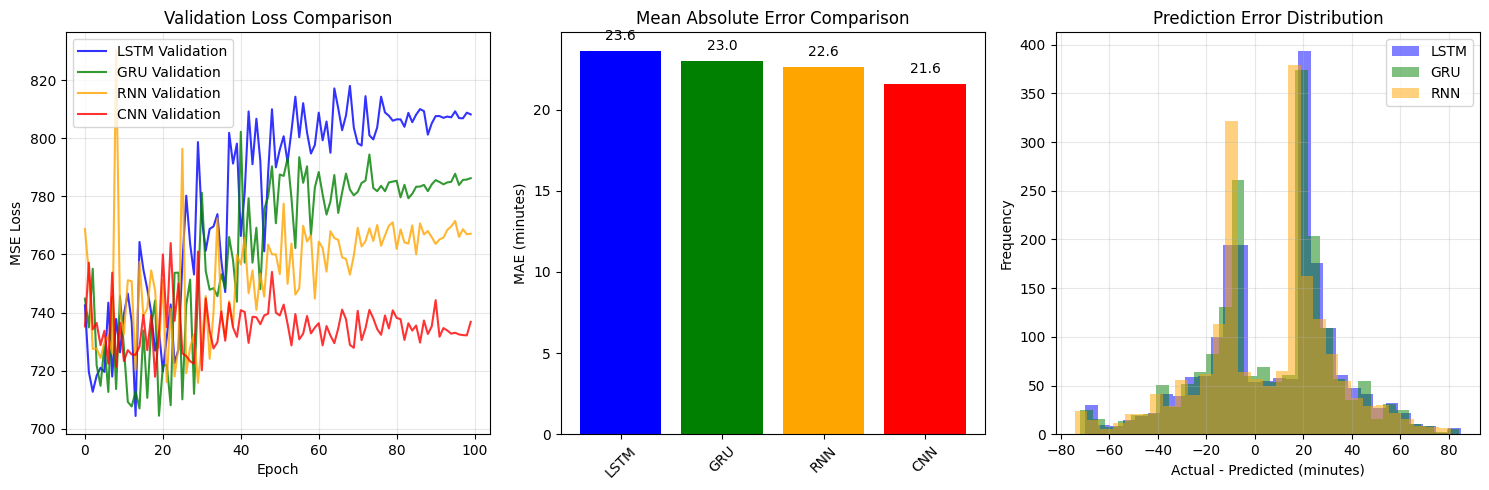

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch.nn.functional as F

class PlayerMinutesRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout_rate=0.2, rnn_type='LSTM'):
        super(PlayerMinutesRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        
        # RNN layers (LSTM, GRU, or vanilla RNN)
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, 
                              batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, 
                             batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        else:
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, 
                             batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)  # Predict next week's minutes
        
    def forward(self, x):
        # Reshape for RNN: (batch_size, sequence_length, input_size)
        x = x.unsqueeze(-1)  # Add feature dimension
        
        # RNN forward pass
        if self.rnn_type == 'LSTM':
            rnn_out, (hidden, cell) = self.rnn(x)
        else:
            rnn_out, hidden = self.rnn(x)
        
        # Take the last output from the sequence
        last_output = rnn_out[:, -1, :]  # (batch_size, hidden_size)
        
        # Apply dropout
        x = self.dropout(last_output)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

def train_rnn_model(X_train, y_train, X_test, y_test, epochs=500, batch_size=32, lr=0.001, rnn_type='LSTM'):
    """
    Train the RNN model
    """
    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model, loss function, and optimizer
    model = PlayerMinutesRNN(input_size=1, hidden_size=64, num_layers=2, 
                            dropout_rate=0.2, rnn_type=rnn_type)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    # Training loop
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs, y_test)
            val_losses.append(val_loss.item())
            
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        scheduler.step(val_loss)
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return model, train_losses, val_losses

def evaluate_rnn_model(model, X_test, y_test, model_name="RNN"):
    """
    Evaluate the trained RNN model
    """
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        
    # Convert to numpy for evaluation
    y_pred = predictions.numpy().flatten()
    y_true = y_test.numpy().flatten()
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"{model_name} Model Performance:")
    print(f"MAE: {mae:.2f} minutes")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f} minutes")
    
    return y_pred, y_true

def compare_models(X_train, y_train, X_test, y_test, epochs=500):
    """
    Train and compare different RNN architectures
    """
    results = {}
    
    # Train different RNN types
    rnn_types = ['LSTM', 'GRU', 'RNN']
    
    for rnn_type in rnn_types:
        print(f"\n{'='*50}")
        print(f"Training {rnn_type} model...")
        print(f"{'='*50}")
        
        model, train_losses, val_losses = train_rnn_model(
            X_train, y_train, X_test, y_test, 
            epochs=epochs, rnn_type=rnn_type
        )
        
        print(f"\nEvaluating {rnn_type} model...")
        predictions, true_values = evaluate_rnn_model(model, X_test, y_test, rnn_type)
        
        results[rnn_type] = {
            'model': model,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'predictions': predictions,
            'true_values': true_values
        }
    
    return results

# Train and evaluate RNN models
print("Training RNN models...")
rnn_results = compare_models(X_train, y_train, X_test, y_test, epochs=500)

# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

rnn_types = ['LSTM', 'GRU', 'RNN']
colors = ['blue', 'green', 'orange']

# Plot training curves for each RNN type
for i, (rnn_type, color) in enumerate(zip(rnn_types, colors)):
    result = rnn_results[rnn_type]
    
    # Training curves
    axes[0, i].plot(result['train_losses'], label='Training Loss', color=color, alpha=0.7)
    axes[0, i].plot(result['val_losses'], label='Validation Loss', color=color, linestyle='--')
    axes[0, i].set_title(f'{rnn_type} Training Curves')
    axes[0, i].set_xlabel('Epoch')
    axes[0, i].set_ylabel('MSE Loss')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)
    
    # Prediction scatter plots
    axes[1, i].scatter(result['true_values'], result['predictions'], 
                      alpha=0.5, color=color, s=20)
    axes[1, i].plot([0, 90], [0, 90], 'r--', label='Perfect Prediction', alpha=0.8)
    axes[1, i].set_xlabel('Actual Minutes')
    axes[1, i].set_ylabel('Predicted Minutes')
    axes[1, i].set_title(f'{rnn_type} Predictions vs Actual')
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)
    axes[1, i].set_xlim(0, 95)
    axes[1, i].set_ylim(0, 95)

plt.tight_layout()
plt.show()

# Compare all models (including CNN) side by side
print(f"\n{'='*60}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*60}")

# Calculate metrics for comparison
for rnn_type in rnn_types:
    result = rnn_results[rnn_type]
    mae = mean_absolute_error(result['true_values'], result['predictions'])
    mse = mean_squared_error(result['true_values'], result['predictions'])
    rmse = np.sqrt(mse)
    
    print(f"{rnn_type:8} | MAE: {mae:6.2f} | MSE: {mse:8.2f} | RMSE: {rmse:6.2f}")

# Add CNN results for comparison (assuming you have them)
if 'cnn_predictions' in globals() and 'cnn_true' in globals():
    cnn_mae = mean_absolute_error(cnn_true, cnn_predictions)
    cnn_mse = mean_squared_error(cnn_true, cnn_predictions)
    cnn_rmse = np.sqrt(cnn_mse)
    print(f"{'CNN':8} | MAE: {cnn_mae:6.2f} | MSE: {cnn_mse:8.2f} | RMSE: {cnn_rmse:6.2f}")

print(f"{'='*60}")

# Create a final comparison plot
plt.figure(figsize=(15, 5))

# Plot 1: Loss comparison
plt.subplot(1, 3, 1)
for i, (rnn_type, color) in enumerate(zip(rnn_types, colors)):
    result = rnn_results[rnn_type]
    plt.plot(result['val_losses'], label=f'{rnn_type} Validation', color=color, alpha=0.8)

if 'val_losses' in globals():
    plt.plot(val_losses, label='CNN Validation', color='red', alpha=0.8)

plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: MAE comparison
plt.subplot(1, 3, 2)
mae_scores = []
model_names = []

for rnn_type in rnn_types:
    result = rnn_results[rnn_type]
    mae = mean_absolute_error(result['true_values'], result['predictions'])
    mae_scores.append(mae)
    model_names.append(rnn_type)

if 'cnn_predictions' in globals() and 'cnn_true' in globals():
    cnn_mae = mean_absolute_error(cnn_true, cnn_predictions)
    mae_scores.append(cnn_mae)
    model_names.append('CNN')

bars = plt.bar(model_names, mae_scores, color=colors + ['red'])
plt.title('Mean Absolute Error Comparison')
plt.ylabel('MAE (minutes)')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, score in zip(bars, mae_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{score:.1f}', ha='center', va='bottom')

# Plot 3: Prediction distribution
plt.subplot(1, 3, 3)
for i, (rnn_type, color) in enumerate(zip(rnn_types, colors)):
    result = rnn_results[rnn_type]
    residuals = result['true_values'] - result['predictions']
    plt.hist(residuals, bins=30, alpha=0.5, label=f'{rnn_type}', color=color)

plt.title('Prediction Error Distribution')
plt.xlabel('Actual - Predicted (minutes)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()